In [108]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn

%matplotlib inline

In [174]:
data = pd.read_csv(r'../../output/metrics.csv')
df = pd.DataFrame(data)
df['title'] = df['level_0']
attack_series = []
attack_IDs = []
dimensions_series = []
for _, row in df.iterrows():
    attack_series.append(row['level_1'].split('/')[-2])

df['attack'] = attack_series

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))
    dimensions_series.append(dimension)
    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs
df['dimension'] = dimensions_series
df = df.drop(['Unnamed: 0',
         'temporal_canny-series',
         'temporal_cross_correlation-series', 
         'temporal_difference-series', 
         'temporal_histogram_distance-series', 
         'temporal_histogram_distance-cosine',
         'level_0', 
#           'dimension',
#           'temporal_canny-cosine',
#           'temporal_cross_correlation-cosine',
#               'temporal_difference-cosine',
         'level_1'],axis=1)

In [175]:
df.head(25)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,title,attack,attack_ID,dimension
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p,1,1080
1,0.000566,0.670932,7.154334e-07,0.186423,0.000021,0.585142,0.587441,78.516691,../../data/1080p/-8ygLPzgpsg.mp4,1080p_watermark,0,1080
2,0.001139,1.866004,5.874493e-04,3.274284,0.000036,0.361467,0.048735,3.019776,../../data/1080p/-8ygLPzgpsg.mp4,1080p_flip_vertical,0,1080
3,0.001072,1.812684,8.232710e-04,4.191308,0.000043,0.403333,0.091211,1.929483,../../data/1080p/-8ygLPzgpsg.mp4,1080p_rotate_90_clockwise,0,1080
4,0.000633,0.630162,8.913559e-07,0.385323,0.000296,1.154801,11.787850,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_vignette,0,1080
5,0.000493,0.556471,6.946701e-06,0.127974,0.000175,1.431690,16.136381,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_black_and_white,0,1080
6,0.000671,0.647693,3.210575e-08,0.012719,0.000474,2.022201,0.266372,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_low_bitrate_4,0,1080
7,0.000601,0.615467,3.528216e-09,0.005353,0.000135,0.702022,0.080409,96.411326,../../data/1080p/-8ygLPzgpsg.mp4,720p,1,720
8,0.000672,0.648275,8.818017e-07,0.391206,0.000490,1.339839,11.799543,NaN,../../data/1080p/-8ygLPzgpsg.mp4,720p_vignette,0,720
9,0.000624,0.627251,6.814093e-06,0.131143,0.000352,1.794147,16.145431,NaN,../../data/1080p/-8ygLPzgpsg.mp4,720p_black_and_white,0,720


In [176]:
df.describe()

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
count,5796.000000,5796.000000,5.796000e+03,5796.000000,5796.000000,5796.000000,5796.000000,3174.000000,5796.000000,5796.000000
mean,0.124845,12196.617817,2.942489e-03,1.671773,0.021534,3.302123,5.355903,40.343494,0.142857,504.000000
std,0.246705,50237.227818,1.237253e-02,2.582384,0.070417,2.904630,9.728277,40.267544,0.349957,316.001944
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.000000
25%,0.000873,1.099166,3.474633e-07,0.103534,0.000725,1.348963,0.165798,1.475565,0.000000,240.000000
50%,0.003933,3.552987,4.852876e-06,0.352134,0.003272,2.496744,0.604480,9.992767,0.000000,420.000000
75%,0.090100,12.470781,3.877885e-04,2.447800,0.013115,4.241309,5.357450,84.832563,0.000000,720.000000
max,0.974069,378978.958427,1.665425e-01,12.605094,0.823593,22.774383,56.174166,99.590587,1.000000,1080.000000


In [177]:
df_corr = df.corr()
plt.figure(figsize=(10,10))
corr = df_corr.corr('spearman')
corr.style.background_gradient().set_precision(2)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
temporal_canny-cosine,1,0.88,0.42,0.49,0.48,0.079,0.091,-0.35,-0.16,-0.079
temporal_canny-euclidean,0.88,1,0.22,0.41,0.59,0.13,0.079,-0.24,-0.14,-0.19
temporal_cross_correlation-cosine,0.42,0.22,1,0.92,-0.33,-0.62,-0.7,-0.94,-0.28,0.56
temporal_cross_correlation-euclidean,0.49,0.41,0.92,1,-0.16,-0.43,-0.54,-0.95,-0.49,0.36
temporal_difference-cosine,0.48,0.59,-0.33,-0.16,1,0.73,0.47,0.36,0.055,-0.73
temporal_difference-euclidean,0.079,0.13,-0.62,-0.43,0.73,1,0.73,0.55,-0.2,-0.94
temporal_histogram_distance-euclidean,0.091,0.079,-0.7,-0.54,0.47,0.73,1,0.59,-0.067,-0.7
vmaf,-0.35,-0.24,-0.94,-0.95,0.36,0.55,0.59,1,0.47,-0.45
attack_ID,-0.16,-0.14,-0.28,-0.49,0.055,-0.2,-0.067,0.47,1,0.28
dimension,-0.079,-0.19,0.56,0.36,-0.73,-0.94,-0.7,-0.45,0.28,1


<Figure size 720x720 with 0 Axes>

In [178]:
train_prop = 0.8

df_1 = df[df['attack_ID'] == 1]
df_0 = df[df['attack_ID'] == 0]


num_train = int(df_1.shape[0]*0.8)
df_train = df_1[0:num_train]
df_test = df_1[num_train:]
df_attacks = df_0

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_attacks = df_attacks.sample(frac=1)

X_train = df_train.drop(['title',
                         'attack', 
                         'attack_ID',
                         'dimension',
                         'vmaf'],axis=1)
X_train = np.asarray(X_train)

X_test = df_test.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',  
                     'vmaf'],axis=1)
X_test = np.asarray(X_test)

X_attacks = df_attacks.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',
                     'vmaf'],axis=1)

X_attacks = np.asarray(X_attacks)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of test: {}'.format(X_test.shape))
print('Shape of attacks: {}'.format(X_attacks.shape))

Shape of train: (662, 7)
Shape of test: (166, 7)
Shape of attacks: (4968, 7)


Text(0, 0.5, 'Explained variance')

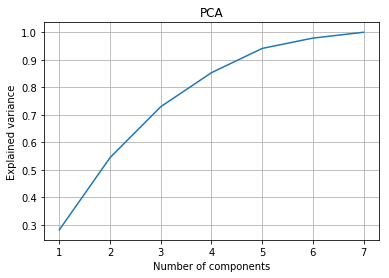

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

x_train = ss.fit_transform(X_train)
x_test = ss.transform(X_test)
x_attacks = ss.transform(X_attacks)

variances = []
components = reversed(range(1,x_test.shape[1]+1))
for i in components:
    pca = PCA(n_components=i)
    pca.fit(x_train)
    variances.append(sum(pca.explained_variance_ratio_))
plt.plot(list(reversed(range(1,x_test.shape[1]+1))), variances)   
plt.grid()
plt.title('PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [10]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


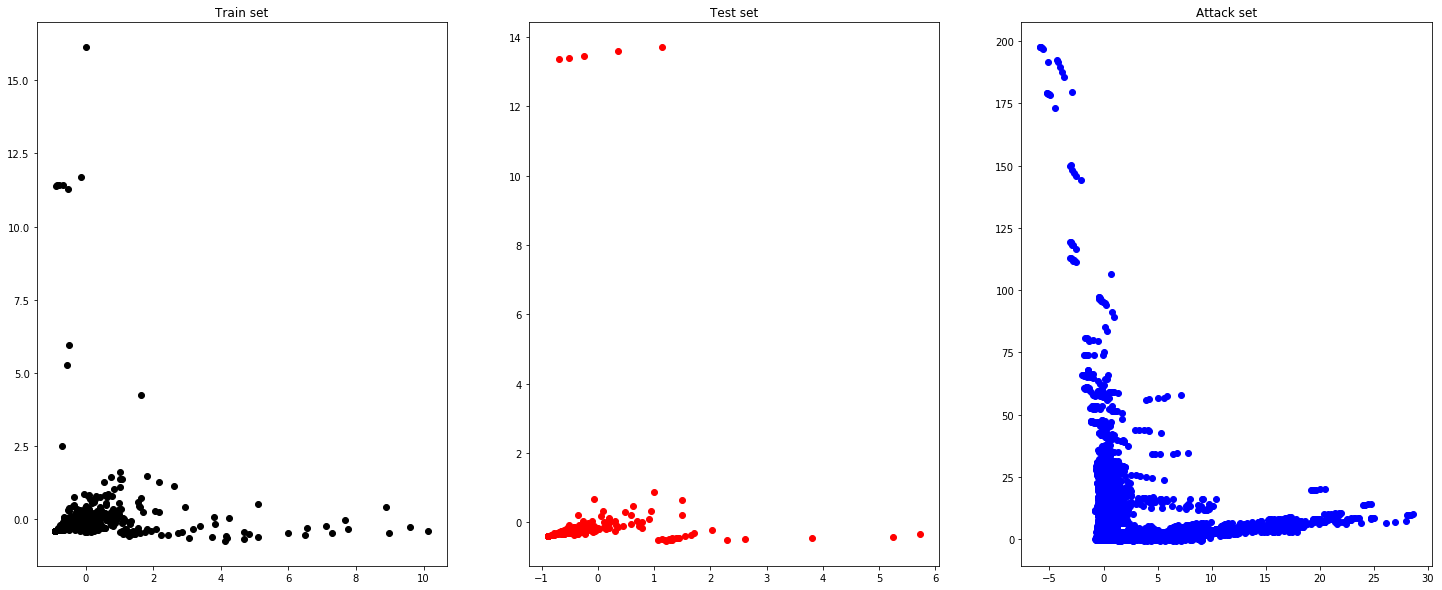

In [11]:
f, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].set_title("Train set")
ax[1].set_title("Test set")
ax[2].set_title("Attack set")
ax[0].scatter(X_reduced[:,0], X_reduced[:,1], color='black')
ax[1].scatter(test_reduced[:,0], test_reduced[:,1], color='red')
ax[2].scatter(attack_reduced[:,0], attack_reduced[:,1], color='blue')

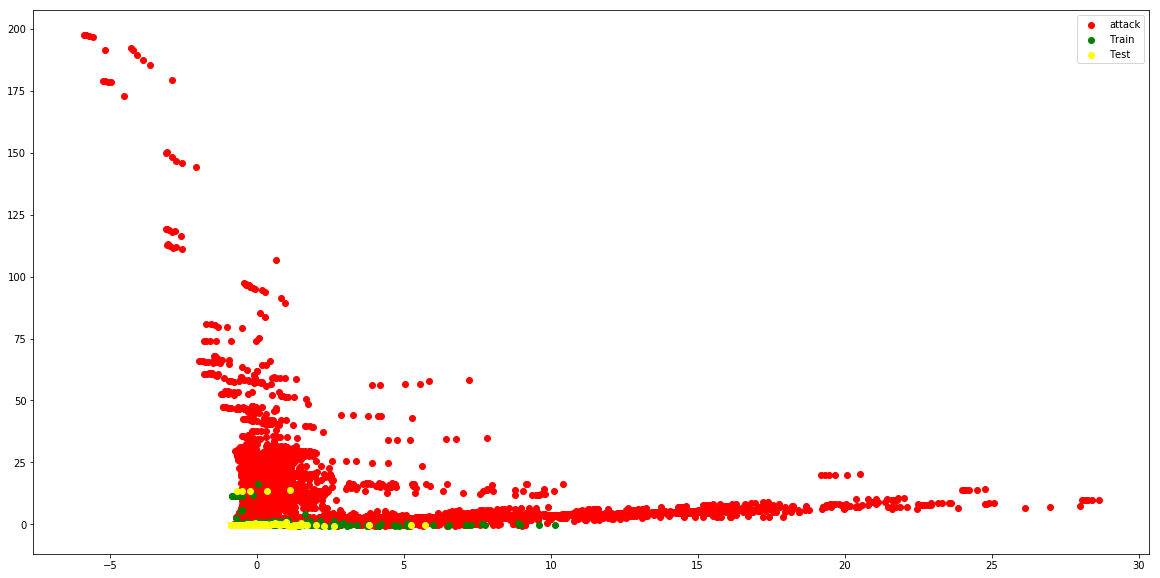

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(attack_reduced[:,0], attack_reduced[:,1], color='red', label='attack')
plt.scatter(X_reduced[:,0], X_reduced[:,1], color='green', label='Train')
plt.scatter(test_reduced[:,0], test_reduced[:,1], color='yellow', label='Test')
plt.legend()


In [82]:
from sklearn import metrics 

nus = [0.1, 0.01, 0.001, 0.0001]

svm_results = pd.DataFrame(columns=['gamma', 'nu', 'n_components', 'train_acc', 
                                    'test_acc', 'attack_acc', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)

    gammas = [X_reduced.shape[1], 2*X_reduced.shape[1], X_reduced.shape[1]/2, 'auto']                                 
    for nu in nus:
        for gamma in gammas:
            classifier = svm.OneClassSVM(kernel='rbf',gamma=gamma, nu=nu, cache_size=5000)
            classifier.fit(X_reduced)
            y_pred_train = classifier.predict(X_reduced)
            y_pred_test = classifier.predict(test_reduced)
            y_pred_outliers = classifier.predict(attack_reduced)
            n_accurate_train = y_pred_train[y_pred_train == 1].size
            n_accurate_test = y_pred_test[y_pred_test == 1].size
            n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size
            
            
            fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
            fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)
            
            svm_results = svm_results.append({'nu': nu, 'gamma': gamma, 'n_components': n, 'train_acc': n_accurate_train/X_reduced.shape[0],
                           'test_acc': n_accurate_train/X_reduced.shape[0], 'attack_acc': n_accurate_outliers/attack_reduced.shape[0],
                           'model': 'svm', 'auc': metrics.auc(fpr, tpr), 'f_beta': fb}, ignore_index=True)


/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
svm_results.sort_values('f_beta', ascending=False).head(10)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta
90,1,0.0010,2,0.972810,0.972810,0.690016,svm,0.829948,0.948018
102,0.5,0.0100,1,0.981873,0.981873,0.231884,svm,0.612930,0.940097
87,auto,0.0100,2,0.981873,0.981873,0.664654,svm,0.811243,0.934540
84,2,0.0100,2,0.956193,0.956193,0.708736,svm,0.824247,0.919901
71,auto,0.0100,3,0.977341,0.977341,0.702496,svm,0.821128,0.919481
106,0.5,0.0010,1,0.942598,0.942598,0.313003,svm,0.635417,0.911207
59,auto,0.0010,4,0.963746,0.963746,0.717995,svm,0.822853,0.908748
75,auto,0.0010,3,0.971299,0.971299,0.704509,svm,0.816110,0.907853
31,auto,0.0001,6,0.950151,0.950151,0.728663,svm,0.825175,0.903565
98,0.5,0.1000,1,0.927492,0.927492,0.436795,svm,0.688277,0.901981


In [71]:
svm_results.sort_values('auc', ascending=False).head(20)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f1
54,2,0.0100,4,0.903323,0.903323,0.848027,svm,0.857749,0.858022
58,2,0.0010,4,0.879154,0.879154,0.853865,svm,0.851631,0.840546
38,2.5,0.0100,5,0.877644,0.877644,0.892915,svm,0.844048,0.789276
81,4,0.1000,2,0.907855,0.907855,0.775966,svm,0.842802,0.894878
85,4,0.0100,2,0.941088,0.941088,0.763688,svm,0.839675,0.899979
42,2.5,0.0010,5,0.803625,0.803625,0.893921,svm,0.838527,0.777398
48,4,0.1000,4,0.859517,0.859517,0.887077,svm,0.838117,0.782970
89,4,0.0010,2,0.879154,0.879154,0.811393,svm,0.836419,0.849778
90,1,0.0010,2,0.972810,0.972810,0.690016,svm,0.829948,0.948018
43,auto,0.0010,5,0.962236,0.962236,0.743760,svm,0.829711,0.898666


In [ ]:
# Let's create a metric in order to find a best model from that metric
# We will get just accuracies from test y attack above 0.7, and will add them

In [ ]:
def metric(row, th=0.7):
    if row['test_acc'] < th or row['attack_acc'] < th:
        return 0
    else:
        return row['test_acc'] + row['attack_acc']

In [ ]:
svm_results['score'] = svm_results.apply(metric, axis=1)

In [ ]:
svm_results[svm_results['test_acc'] > svm_results['attack_acc']].sort_values('score', ascending=False).head(10)

In [74]:
from sklearn.ensemble import IsolationForest

estimators = [25, 50, 100, 150, 200, 500]
contaminations = [0.01, 0.1]
isolation_results = pd.DataFrame(columns=['estimators', 'contamination', 'n_components', 'max_features',
                                          'test_acc', 'attack_acc', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)
    max_features = list(range(1, n + 1))
    for estimator in estimators:
        for contamination in contaminations:
            for max_feature in max_features:
                classifier = IsolationForest(n_estimators=estimator,
                                             contamination=contamination,
                                             max_features=max_feature,
                                            n_jobs=5)
                
                classifier.fit(X_reduced)
                y_pred_train = classifier.predict(X_reduced)
                y_pred_test = classifier.predict(test_reduced)
                y_pred_outliers = classifier.predict(attack_reduced)
                n_error_train = y_pred_train[y_pred_train == 1].size
                n_error_test = y_pred_test[y_pred_test == 1].size
                n_error_outliers = y_pred_outliers[y_pred_outliers == -1].size
                
                fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
                
                fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)

                isolation_results = isolation_results.append({'estimators': estimator, 'contamination': contamination,
                                                              'n_components': n, 'max_features': max_feature,
                                                              'train_acc': n_error_train/X_reduced.shape[0],
                                                              'test_acc': n_error_train/X_reduced.shape[0],
                                                              'attack_acc': n_error_outliers/attack_reduced.shape[0],
                                                              'model': 'isolation_forest',
                                                              'auc': metrics.auc(fpr, tpr),
                                                              'f_beta': fb}, ignore_index=True)

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

In [ ]:
isolation_results['score'] = isolation_results.apply(metric, axis=1)

In [ ]:
isolation_results[isolation_results['test_acc'] > isolation_results['attack_acc']].sort_values('test_acc', ascending=False).head(10)

In [75]:
isolation_results.sort_values('f_beta', ascending=False).head(10)

,estimators,contamination,n_components,max_features,test_acc,attack_acc,model,auc,f_beta,train_acc
4,25,0.01,7,5,0.989426,0.572665,isolation_forest,0.786333,0.969093,0.989426
16,50,0.01,7,3,0.989426,0.550121,isolation_forest,0.775060,0.967515,0.989426
60,200,0.01,7,5,0.989426,0.540660,isolation_forest,0.770330,0.966855,0.989426
1,25,0.01,7,2,0.989426,0.523148,isolation_forest,0.761574,0.965634,0.989426
200,200,0.01,5,5,0.989426,0.500805,isolation_forest,0.750403,0.964082,0.989426
180,100,0.01,5,5,0.989426,0.497786,isolation_forest,0.748893,0.963873,0.989426
20,50,0.01,7,7,0.989426,0.496176,isolation_forest,0.748088,0.963761,0.989426
58,200,0.01,7,3,0.989426,0.494163,isolation_forest,0.747081,0.963621,0.989426
43,150,0.01,7,2,0.989426,0.491747,isolation_forest,0.745874,0.963454,0.989426
169,50,0.01,5,4,0.989426,0.486715,isolation_forest,0.743357,0.963106,0.989426


# Let's plot ROCs

In [ ]:
def plot_roc(fpr, tpr, title):
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


classifier = svm.OneClassSVM(kernel='rbf',gamma=2, nu=0.001, cache_size=5000)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'One Class SVM')

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


classifier = IsolationForest(n_estimators=500,
                            contamination=0.1,
                            max_features=2,
                            n_jobs=5)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'Isolation Forest')

In [179]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)
classifier = svm.OneClassSVM(kernel='rbf',gamma=1, nu=0.001, cache_size=5000)
classifier.fit(X_reduced)

OneClassSVM(cache_size=5000, coef0=0.0, degree=3, gamma=1, kernel='rbf',
      max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [180]:
y_pred_outliers = classifier.predict(attack_reduced)

In [181]:
df_attacks_reset = df_attacks.reset_index()

accurate_outliers_df = pd.DataFrame(y_pred_outliers, columns=['pred']) 
undetected = df_attacks_reset[accurate_outliers_df['pred'] == 1][['attack', 'title', 'dimension']]


In [185]:
undetected.groupby(['dimension', 'attack']).count()

title
dimension attack                          
144       144p_black_and_white          38
          144p_flip_vertical            51
          144p_low_bitrate_4            40
          144p_rotate_90_clockwise      47
          144p_vignette                 36
          144p_watermark                38
240       240p_black_and_white          44
          240p_flip_vertical            49
          240p_low_bitrate_4            55
          240p_rotate_90_clockwise      39
          240p_vignette                 49
          240p_watermark                46
360       360p_black_and_white          40
          360p_flip_vertical            42
          360p_low_bitrate_4            43
          360p_rotate_90_clockwise      46
          360p_vignette                 45
          360p_watermark                55
480       480p_black_and_white          38
          480p_flip_vertical            48
          480p_low_bitrate_4            47
          480p_rotate_90_clockwise      51
          480p_vignette                 34
          480p_watermark                49
720       720p_black_and_white          43
          720p_flip_vertical            47
          720p_low_bitrate_4            42
          720p_rotate_90_clockwise      41
          720p_vignette                 36
          720p_watermark                43
1080      1080p_black_and_white         44
          1080p_flip_vertical           41
          1080p_low_bitrate_4           45
          1080p_rotate_90_clockwise     44
          1080p_vignette                37
          1080p_watermark               37

In [169]:
undetected.groupby('title').count().sort_values(['attack'], ascending=False)

,attack
title,
../../data/1080p/znnm1B6aSI4.mp4,17
../../data/1080p/gtVk_l0MPew.mp4,17
../../data/1080p/wM53aihC4MI.mp4,16
../../data/1080p/Y3x25oucpFU.mp4,16
../../data/1080p/U8d1gDaRtuQ.mp4,16
../../data/1080p/MpsOd91U-yk.mp4,16
../../data/1080p/-8ygLPzgpsg.mp4,15
../../data/1080p/BDwG7VkP1OQ.mp4,15
../../data/1080p/wo-Rbbuy8rk.mp4,15
